In [3]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
pip install --quiet git+https://github.com/theislab/scgen.git

Note: you may need to restart the kernel to use updated packages.


In [17]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [18]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [2]:
import anndata
adata = anndata.read_h5ad("../macaque_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

In [3]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.5 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 50% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']

# Now 'semi_labels' contains 70% known labels and 30% NaN
adata.obs['hard_label'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['hard_label'].fillna("Unknown", inplace=True)
adata.obs['hard_label'] = adata.obs['hard_label'].astype('category')

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_22707/845714008.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['RB', 'BB/GB*', 'DB5*', 'DB4', 'RB', ..., 'DB5*', 'RB', 'RB', 'DB5*', 'RB']
Length: 15151
Categories (12, object): ['BB/GB*', 'DB1', 'DB2', 'DB3a', ..., 'FMB', 'IMB', 'OFFx', 'RB']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']
/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_22707/845714008.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [5]:
# Save the new_labels column to a CSV file
adata.obs[['hard_label']].to_csv('../R_macaque/labels/hard_label_macaque_50.csv', index=True)

In [4]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [5]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [15]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [6]:
# Load the pretrained models
adata = adata.copy()
# Setup anndata with the same parameters used for training
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the use

In [7]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

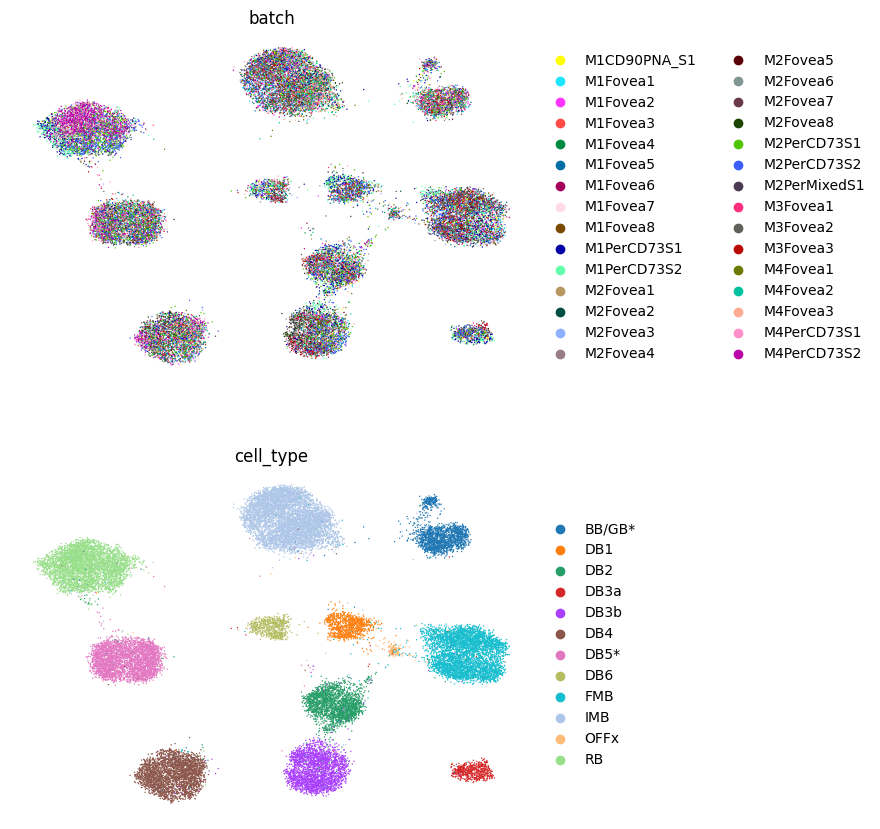

In [8]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [9]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="hard_label",
    unlabeled_category="Unknown",
)

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [10]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [01:19<00:00,  3.93s/it, v_num=1, train_loss_step=456

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [01:19<00:00,  3.97s/it, v_num=1, train_loss_step=456


In [11]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [12]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [13]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

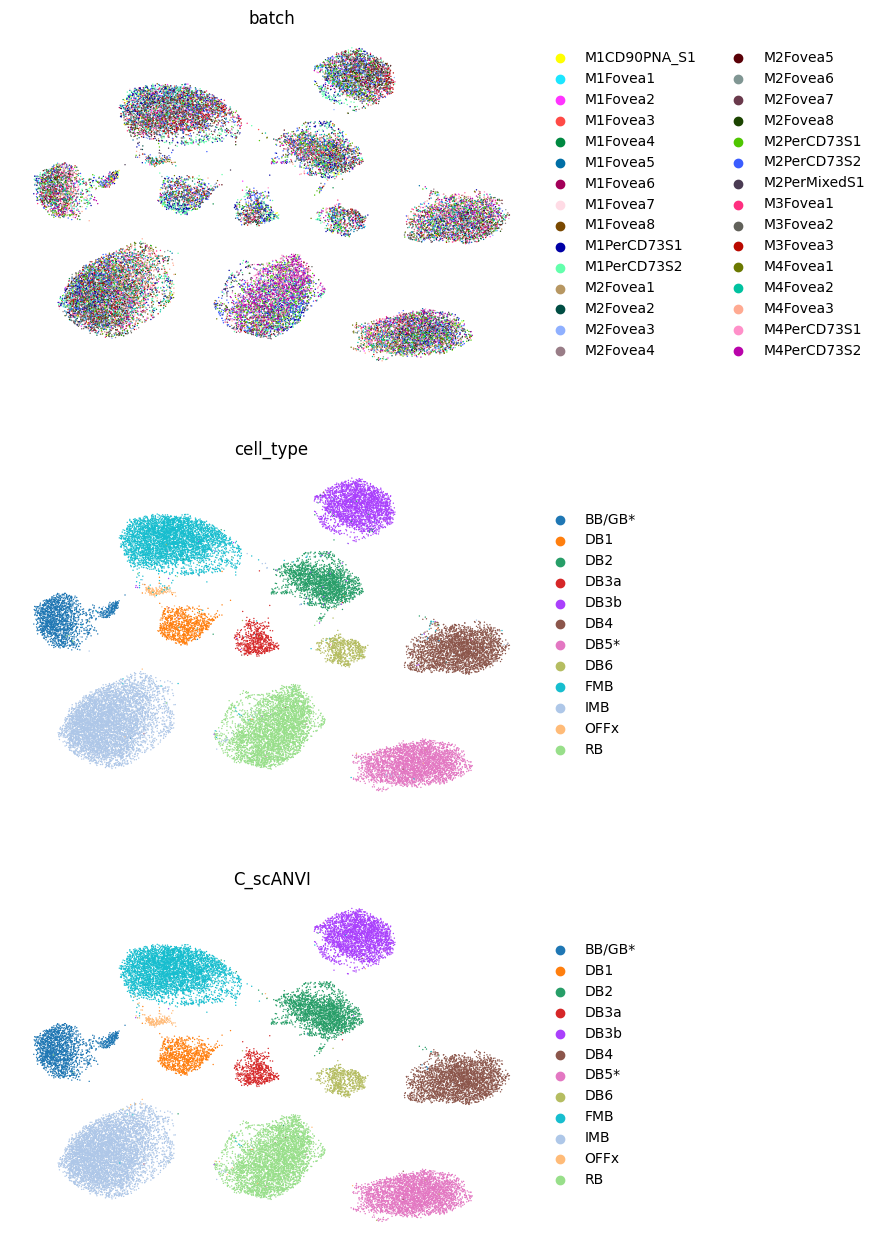

In [14]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [19]:
train = adata.copy()

### Preprocessing Data

In [20]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="hard_label")

## Creating and Training the model¶

In [21]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|▎| 26/100 [05:24<15:24, 12.50s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1003.683. Signaling Trainer to stop.


## Batch-Removal

In [22]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 30302 × 2000
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH', 'hard_label', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [23]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [24]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

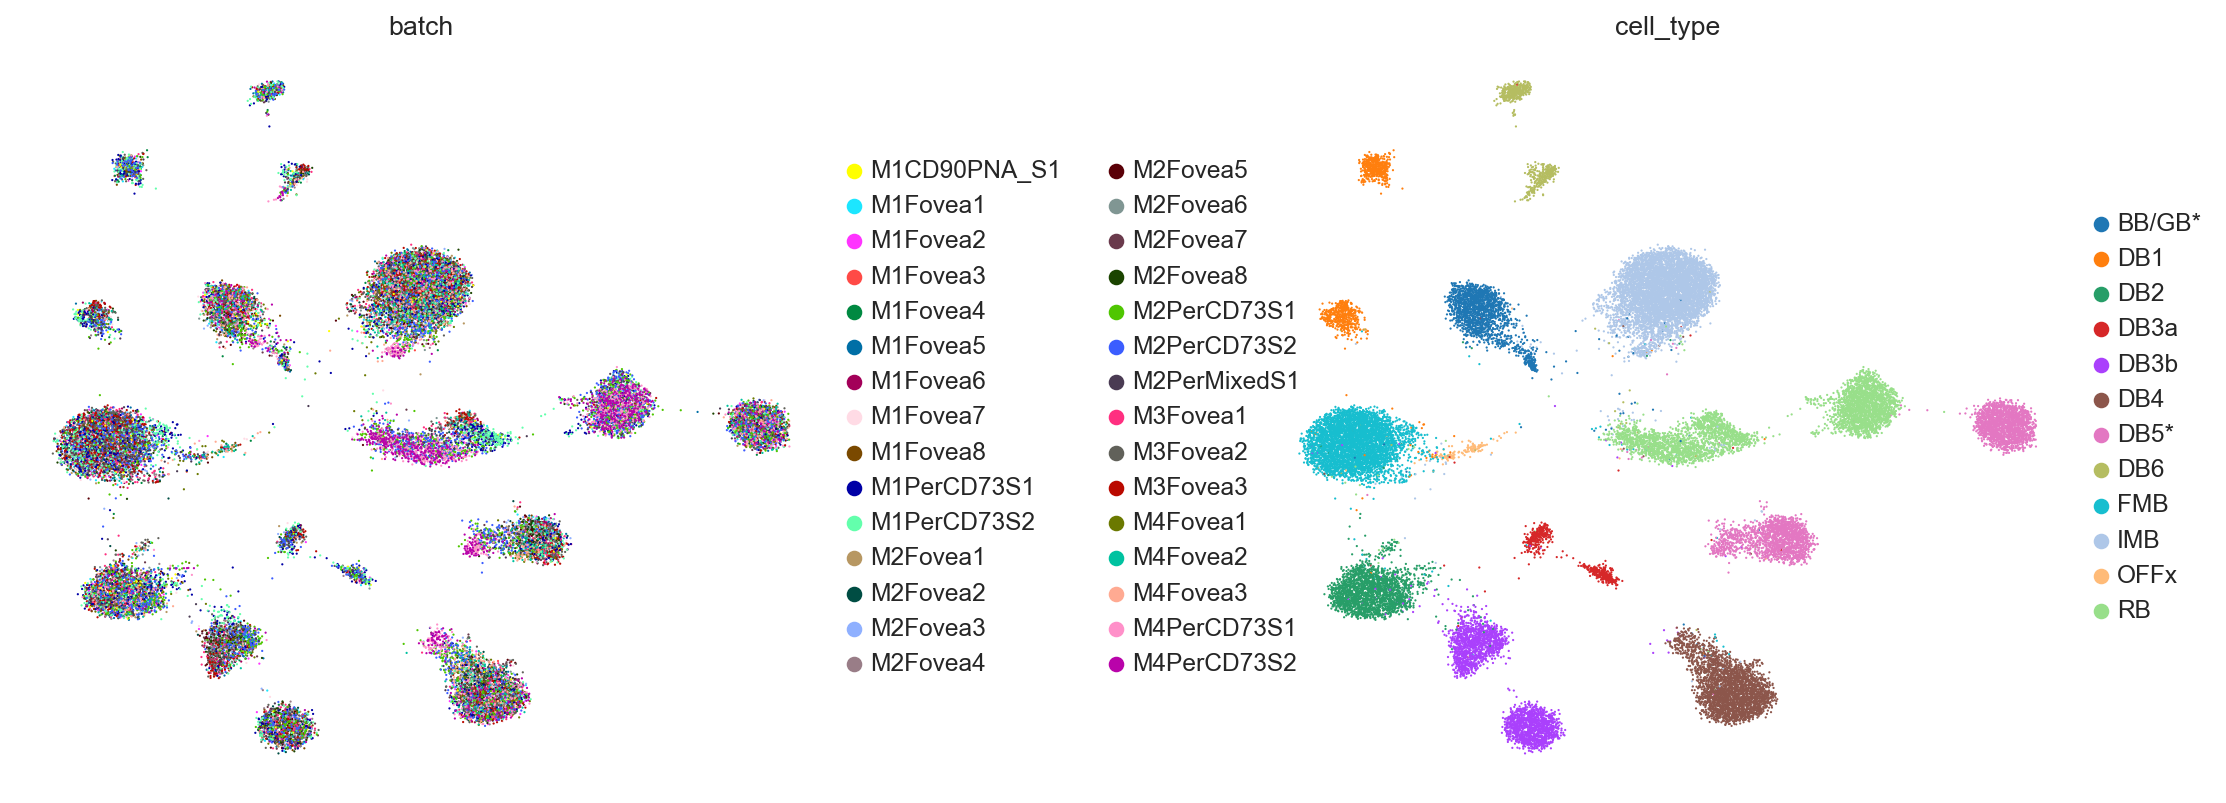

In [25]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [26]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/macaque_stacas_embeddings_randomly_missing_labels_50.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [27]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

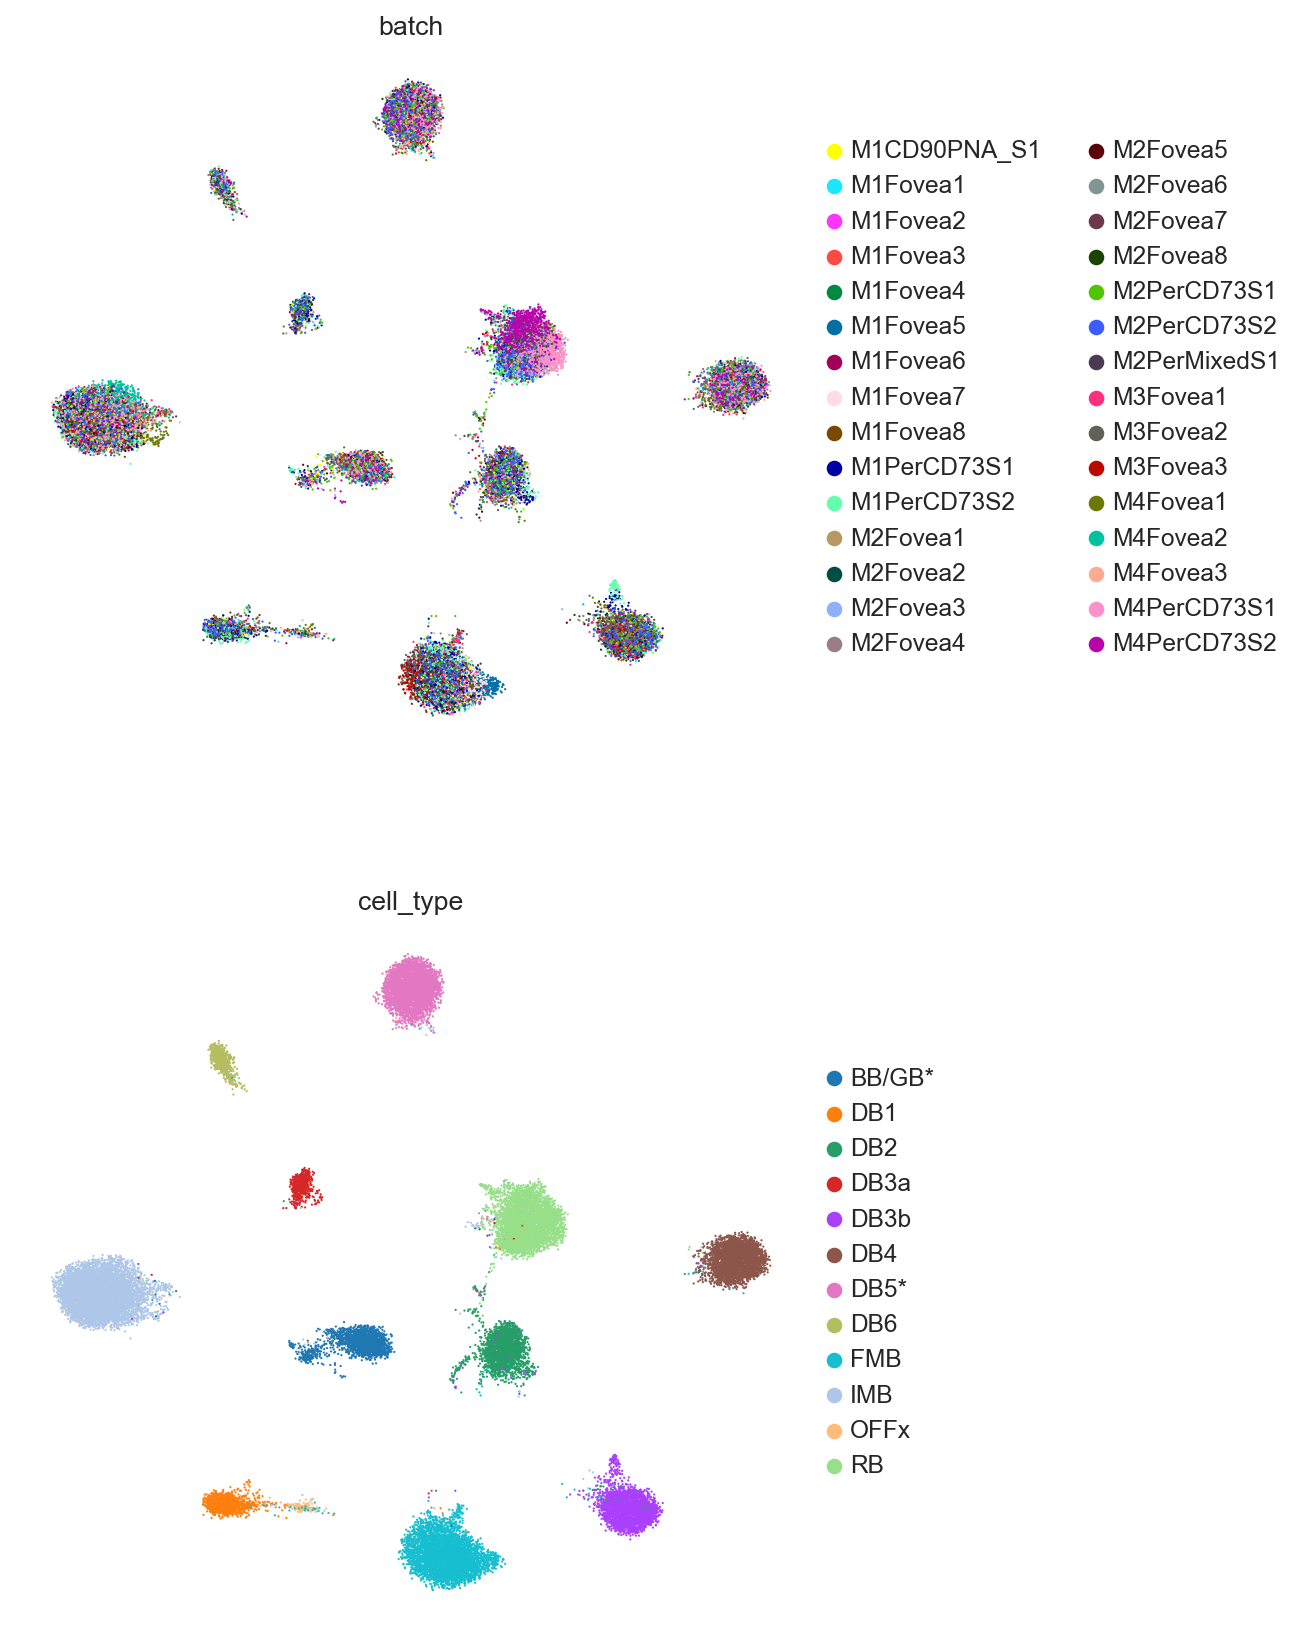

In [28]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [29]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/randomly_missing_macaque_50.csv")


# Metric Evaluation

## read the embeddings

In [28]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/randomly_missing_macaque_50.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [30]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.9699598941976213
resolution: 0.2, nmi: 0.9146052172083932
resolution: 0.3, nmi: 0.902661808235612
resolution: 0.4, nmi: 0.9056079836390611
resolution: 0.5, nmi: 0.9055978497929622
resolution: 0.6, nmi: 0.8913093668551472
resolution: 0.7, nmi: 0.8927584328133633
resolution: 0.8, nmi: 0.886010833965323
resolution: 0.9, nmi: 0.8835502794970538
resolution: 1.0, nmi: 0.8728319899867657
resolution: 1.1, nmi: 0.8683380409556758
resolution: 1.2, nmi: 0.8678017240184626
resolution: 1.3, nmi: 0.8642032078409557
resolution: 1.4, nmi: 0.8631131814665308
resolution: 1.5, nmi: 0.84473018013683
resolution: 1.6, nmi: 0.8412017815516889
resolution: 1.7, nmi: 0.8331890105786092
resolution: 1.8, nmi: 0.8331603521469712
resolution: 1.9, nmi: 0.8156430565300682
resolution: 2.0, nmi: 0.8191939703851691
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9699598941976213
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on re

In [31]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.815301204371759
resolution: 0.2, nmi: 0.9060281062175088
resolution: 0.3, nmi: 0.8956491215544224
resolution: 0.4, nmi: 0.8719340042105229
resolution: 0.5, nmi: 0.8693572845424734
resolution: 0.6, nmi: 0.8690168734828648
resolution: 0.7, nmi: 0.8692833199385371
resolution: 0.8, nmi: 0.8639551023450825
resolution: 0.9, nmi: 0.8545656358458587
resolution: 1.0, nmi: 0.8552078182037838
resolution: 1.1, nmi: 0.8287915114309548
resolution: 1.2, nmi: 0.8352478579520085
resolution: 1.3, nmi: 0.8276517065733769
resolution: 1.4, nmi: 0.8149334471947435
resolution: 1.5, nmi: 0.8120011007684661
resolution: 1.6, nmi: 0.805449947201485
resolution: 1.7, nmi: 0.8065097057537582
resolution: 1.8, nmi: 0.7926740457342236
resolution: 1.9, nmi: 0.7863545009404506
resolution: 2.0, nmi: 0.7760963772191982
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.9060281062175088
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on 

In [32]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.939926425278718
resolution: 0.2, nmi: 0.9036037212992354
resolution: 0.3, nmi: 0.866952223596483
resolution: 0.4, nmi: 0.8710847843975076
resolution: 0.5, nmi: 0.8615113893168685
resolution: 0.6, nmi: 0.848982270727274
resolution: 0.7, nmi: 0.8302828257785116
resolution: 0.8, nmi: 0.8244145194155809
resolution: 0.9, nmi: 0.8244875156161242
resolution: 1.0, nmi: 0.8244901014107182
resolution: 1.1, nmi: 0.8189724623662792
resolution: 1.2, nmi: 0.8154657788910926
resolution: 1.3, nmi: 0.8146143356447721
resolution: 1.4, nmi: 0.8033381184443649
resolution: 1.5, nmi: 0.8034196766548662
resolution: 1.6, nmi: 0.8031802368257991
resolution: 1.7, nmi: 0.8011524996330032
resolution: 1.8, nmi: 0.7939940625820945
resolution: 1.9, nmi: 0.7881643565748505
resolution: 2.0, nmi: 0.7823715734618382
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.939926425278718
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on re

In [33]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/macaque_metrics_randomly_missing_50.csv", index=True)

In [34]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.971013,0.904231,0.941660
ARI_cluster/label,0.982304,0.872363,0.949046
ASW_label,0.686717,0.539651,0.620496
ASW_label/batch,0.928864,0.941366,0.924431
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.982617,0.948133,0.969087
isolated_label_silhouette,0.681735,0.545977,0.616368
graph_conn,0.995363,0.996250,0.994143
kBET,NaN,NaN,NaN
